In [1]:
import os
import os.path as osp
import torch
import argparse
from glob import glob
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import v2
from transformers import GPT2Tokenizer

from models.gpt import GPT2LMHeadModel
from models.clip_vit import ImageEncoder
from clevrx_sample import CLEVRXEvalDataset, change_requires_grad
from utils.eval_utils import top_filtering

SPECIAL_TOKENS = ['<|endoftext|>', '<pad>', '<question>', '<answer>', '<explanation>']

/home/simeon/.anaconda3/envs/nlxgpt/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/simeon/.anaconda3/envs/nlxgpt/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submi

In [2]:
args = argparse.Namespace(
    device='cpu',
    
    split='test',
    
    greyscale=False,
    colorjitter=True,
    flip=False,  
    
    jitter_hue=(-0.5,0.5),  # for max effect: (-0.5, 0.5)
    flip_prob=0.5,
    
    max_seq_len=20,
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    no_sample=True,
    
    load_from_epoch=1,
    image_dir='data/CLEVR_v1.0/images',  # replace with path to CLEVR images
    nle_data_test_path='nle_data/CLEVR-X/clevrX_test.json',
    nle_data_val_path='nle_data/CLEVR-X/clevrX_dev.json',
    
    eval_batch_size=1,
    img_size=224,
)

assert sum([args.colorjitter, args.greyscale, args.flip]) <= 1, 'only one transformation can be activated!'

In [3]:
def load_from_dir(dir):
    abs_dir = osp.abspath(dir)
    model_location = glob(osp.join(abs_dir, '*_model_*'))[0]
    info_file = glob(osp.join(abs_dir, '*_stats_*'))[0]
    #tokenizer_location = glob(osp.join(abs_dir, '*_tokenizer_*'))[0]
    tokenizer_location = 'ckpts/CLEVR-X/clevrx_00/clevrx_nle_gpt2_tokenizer_00'
    
    model = GPT2LMHeadModel.from_pretrained(model_location)
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_location)
    
    infos = torch.load(info_file, map_location=torch.device('cpu'))
    epoch = infos['epoch']
    
    return model, tokenizer, epoch


def sample_sequence(
    img, input_ids, segment_ids, 
    model, image_encoder, tokenizer, 
    args, special_tokens=SPECIAL_TOKENS):

    special_tokens_ids = tokenizer.convert_tokens_to_ids(special_tokens)
    because_token = tokenizer.convert_tokens_to_ids('Ġbecause')

    current_output = []
    img_embeddings = image_encoder(img)
    always_exp = False

    with torch.no_grad():

        for step in range(args.max_seq_len + 1):

            if step == args.max_seq_len:
                break

            outputs = model(input_ids=input_ids,
                            past_key_values=None,
                            attention_mask=None,
                            token_type_ids=segment_ids,
                            position_ids=None,
                            encoder_hidden_states=img_embeddings,
                            encoder_attention_mask=None,
                            labels=None,
                            use_cache=False,
                            return_dict=True)

            lm_logits = outputs.logits
            logits = lm_logits[0, -1, :] / args.temperature
            logits = top_filtering(
                logits, top_k=args.top_k, top_p=args.top_p)
            probs = F.softmax(logits, dim=-1)
            prev = torch.topk(probs, 1)[
                1] if args.no_sample else torch.multinomial(probs, 1)

            if prev.item() in special_tokens_ids:
                break

            # take care of when to start the <explanation> token
            if not always_exp:

                if prev.item() != because_token:
                    new_segment = special_tokens_ids[-2]   # answer segment
                else:
                    # explanation segment
                    new_segment = special_tokens_ids[-1]
                    always_exp = True
            else:
                # explanation segment
                new_segment = special_tokens_ids[-1]

            new_segment = torch.LongTensor([new_segment]).to(args.device)
            current_output.append(prev.item())
            input_ids = torch.cat((input_ids, prev.unsqueeze(0)), dim=1)
            segment_ids = torch.cat(
                (segment_ids, new_segment.unsqueeze(0)), dim=1)

    full_decoded_sequence = tokenizer.decode(
        current_output, skip_special_tokens=True).lstrip()
    
    return full_decoded_sequence

In [4]:
# load model and tokenizer
model_path = f'ckpts/CLEVR-X/clevrx_{str(args.load_from_epoch).rjust(2, "0")}'
model, tokenizer, epoch = load_from_dir(model_path)
model.eval()

# load image encoder
image_encoder = ImageEncoder(args.device).to(args.device)
change_requires_grad(image_encoder, False)
image_encoder.eval()

print('model setup ready')

model setup ready


In [5]:
annot_path = args.nle_data_test_path if args.split == 'test' else args.nle_data_val_path

img_transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

if args.greyscale:
    # convert image to greyscale
    print('add greyscale transformation')
    transformation_list = img_transform.transforms
    inference_transform_fn = transforms.Grayscale(num_output_channels=3)
    transformation_list.insert(1, 
        inference_transform_fn
    )
    img_transform = transforms.Compose(transformation_list)
    
elif args.colorjitter:
    # randomly change hue
    print('add color jitter transformation')
    transformation_list = img_transform.transforms
    inference_transform_fn = v2.ColorJitter(
        # brightness=0, 
        # contrast=0, 
        # saturation=0, 
        hue=args.jitter_hue)
    transformation_list.insert(1, 
        inference_transform_fn
    )
    img_transform = transforms.Compose(transformation_list)
    
elif args.flip:
    # randomelastic transform
    print('add random horizontal flip')
    transformation_list = img_transform.transforms
    inference_transform_fn = transforms.RandomHorizontalFlip(p=args.flip_prob)
    transformation_list.insert(1, 
        inference_transform_fn
    )
    img_transform = transforms.Compose(transformation_list)
        
print(img_transform)

add color jitter transformation
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ColorJitter(hue=(-0.5, 0.5))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [6]:
dataset = CLEVRXEvalDataset(
    path=annot_path,
    transform=img_transform,
    tokenizer=tokenizer,
    max_seq_len=args.max_seq_len,
    img_dir=args.image_dir)

In [7]:
idx = 100

Q: "How many other objects are there of the same material as the small cylinder?"
	 A: "0"
	 Exp 0 : "there are no things that have the same material as a small cylinder"
	 Exp 1 : "there are no things which have the identical material as a small cylinder"

-------------------

Generated Sequence:
"1 because there is the matte cube that has the same material as a small cylinder"


Answer: "1"
Explanation: "there is the matte cube that has the same material as a small cylinder"

-------------------

Image:


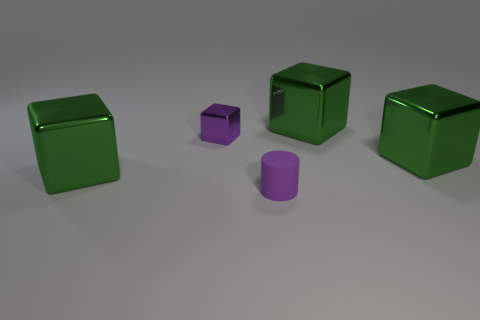

with color jitter (hue range (-0.5, 0.5); can be different for model):


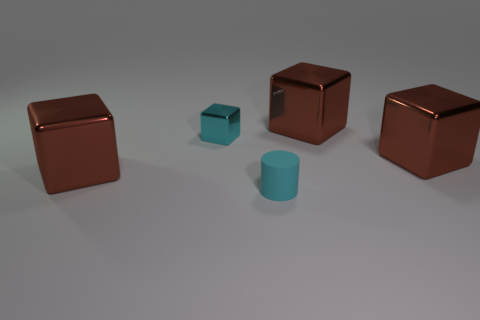

In [8]:
img, qid, input_ids, segment_ids = dataset.__getitem__(idx)

item_data = dataset.data[str(qid.item())]
print(f'Q: "{item_data["question"]}"')

print(f'\t A: "{item_data["answer"]}"')
for i, exp in enumerate(item_data['explanation']):
    print(f'\t Exp {i} : "{exp}"')


print('\n-------------------\n')
print('Generated Sequence:')

_img = img.unsqueeze(0)
_input_ids = input_ids.unsqueeze(0)
_segment_ids = segment_ids.unsqueeze(0)

model_answer_and_explanation = sample_sequence(
    _img, _input_ids, _segment_ids, 
    model, image_encoder, tokenizer, args
)

print(f'"{model_answer_and_explanation}"')

if 'because' in model_answer_and_explanation:
    answer, explanation = tuple(map(
        str.strip, model_answer_and_explanation.split('because')
    ))
    print('\n')
    print(f'Answer: "{answer}"')
    print(f'Explanation: "{explanation}"')

print('\n-------------------\n')
print('Image:')

img_path = osp.join(
    args.image_dir,
    'val' if args.split == 'test' else 'train',
    item_data['image_name']
)

raw_image = Image.open(img_path)
display(raw_image)

if args.greyscale or args.colorjitter or args.flip:
    
    if args.greyscale:
        t = 'greyscale transformation'
    elif args.colorjitter:
        t = f'color jitter (hue range {args.jitter_hue}; can be different for model)'
    elif args.flip:
        t = f'random horizontal flip (p={args.flip_prob}{"; can be different for model" if args.flip_prob < 1 else ""})'
    
    print(f'with {t}:')
    display(inference_transform_fn(raw_image))
    
else: 
    print('No transformations applied to the image')